In [2]:
# Notebook configuration
HNSWLIB_RESULTS_DIR = "./results"

In [3]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
import ipywidgets as widgets

In [4]:
# Load CSV
vanilla_csvs = []
gxl_csvs = []

for root, dir, files in os.walk(HNSWLIB_RESULTS_DIR):
    #print(root,dir, files)
    for file in files:
        if 'vanilla' in file:
            if file.endswith(".csv"):
                fpath = os.path.join(root, file)
                vanilla_csvs.append(fpath)
        elif 'gxl' in file:
            if file.endswith(".csv"):
                fpath = os.path.join(root, file)
                gxl_csvs.append(fpath)

if len(vanilla_csvs)==0:
    raise Exception("No CSVs found in vanilla!")
print("found %d CSV files for vanilla" % len(vanilla_csvs))
if len(gxl_csvs)==0:
    raise Exception("No CSVs found in gxl!")
print("found %d CSV files for gxl" % len(gxl_csvs))

found 7 CSV files for vanilla
found 1 CSV files for gxl


In [5]:
# Load to df
vanilla_dfs = []
gxl_dfs = []

for csv in vanilla_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    vanilla_dfs.append(df)

for csv in gxl_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
vanilla_df = pd.concat( vanilla_dfs )
gxl_df = pd.concat( gxl_dfs )
print("There are %d rows" % vanilla_df.shape[0])
print("There are %d rows" % gxl_df.shape[0])
vanilla_df.head(10)

Concatenating into one master dataframe...
There are 7007 rows
There are 1001 rows


,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances
0,0,build,2023-11-07 01:56:04.808631,2023-11-07 03:53:58.348120,7073,seconds,deep-500M,500000000,64,32,-1,-1,-1
1,1,search,2023-11-07 03:53:58.348211,2023-11-07 03:53:58.348730,519,microseconds,deep-500M,500000000,-1,-1,50,[[ 81481139 202094184 167532067 252222141 941...,[[0.25876737 0.2609731 0.2640561 0.26658046 ...
2,2,search,2023-11-07 03:53:58.348745,2023-11-07 03:53:58.349294,549,microseconds,deep-500M,500000000,-1,-1,50,[[237397391 137200318 444098004 439751443 4055...,[[0.18900526 0.19116533 0.19486696 0.20361489 ...
3,3,search,2023-11-07 03:53:58.349304,2023-11-07 03:53:58.349708,404,microseconds,deep-500M,500000000,-1,-1,50,[[ 44979692 129825681 297191092 490562058 2295...,[[0.11710042 0.11711603 0.12336826 0.12547368 ...
4,4,search,2023-11-07 03:53:58.349715,2023-11-07 03:53:58.350212,497,microseconds,deep-500M,500000000,-1,-1,50,[[178520344 75592195 366115839 172374366 3209...,[[0.16670585 0.17628407 0.17816174 0.17945719 ...
5,5,search,2023-11-07 03:53:58.350220,2023-11-07 03:53:58.350755,535,microseconds,deep-500M,500000000,-1,-1,50,[[404121991 475386405 341624173 324516235 3372...,[[0.07216173 0.07356524 0.08056676 0.0812093 ...
6,6,search,2023-11-07 03:53:58.350762,2023-11-07 03:53:58.351111,349,microseconds,deep-500M,500000000,-1,-1,50,[[485983988 425106457 216145208 250420461 3671...,[[0.02545977 0.05466795 0.0681721 0.0810253 ...
7,7,search,2023-11-07 03:53:58.351117,2023-11-07 03:53:58.351334,217,microseconds,deep-500M,500000000,-1,-1,50,[[484893548 37686298 310717838 129623419 2332...,[[0.01901889 0.02497619 0.0272001 0.02773201 ...
8,8,search,2023-11-07 03:53:58.351340,2023-11-07 03:53:58.351818,478,microseconds,deep-500M,500000000,-1,-1,50,[[385075139 248956422 290868424 243642495 813...,[[0.01997817 0.04155678 0.08993506 0.11949784 ...
9,9,search,2023-11-07 03:53:58.351829,2023-11-07 03:53:58.352221,392,microseconds,deep-500M,500000000,-1,-1,50,[[408798538 223189428 216661141 66394195 4894...,[[0.14515042 0.1579994 0.18859518 0.18981779 ...


latest gsi fvs train time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.051799866799866805, 0.07371017871017871, 0.08143217893217893, 0.0909032634032634, 0.09556887556887557, 0.10185980685980686, 0.11046065046065047]


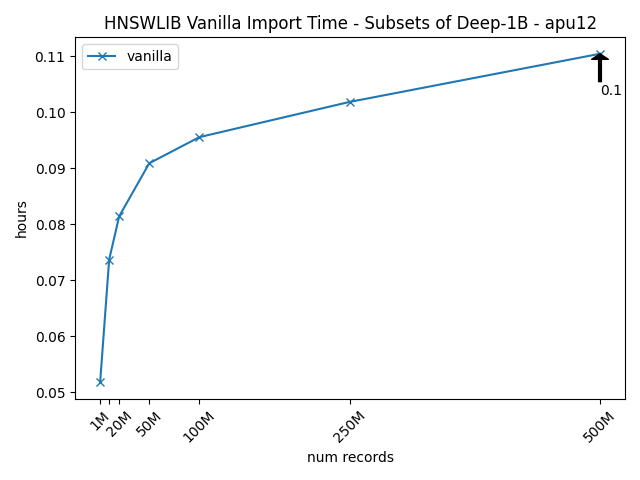

In [7]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_wall_import_time = \
    vanilla_df.groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_wall_import_time.index:
    x = idx
    xs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("latest gsi fvs train time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Import Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_wall_import_time.png")